In [1]:
import scipy.io
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from fancy_plots import fancy_plots_3, plot_states_angles, plot_states_position, plot_states_velocity_lineal, plot_states_velocity_angular
from fancy_plots import fancy_plots_2, plot_control_states
%matplotlib inline  

In [2]:
def get_odometry(data, angle, vx, vy, vz, wx, wy, wz, vel_control, steer_control):
    # Get size of the data
    i, j = data.shape
    # Init empty values
    x = np.zeros((1, j), dtype = np.double)
    y = np.zeros((1, j), dtype = np.double)
    z = np.zeros((1, j), dtype = np.double)
    quatenions = np.zeros((4, j), dtype = np.double)
    orientation_aux = np.zeros((3, j), dtype = np.double)
    
    for k in range(0, j):
        
        # Get Position
        x[:, k] = data[0, k]
        y[:, k] = data[1, k]
        z[:, k] = 0
        
        # Get quaternion
        quatenions[:, k] = [data[2, k], data[3, k], data[4, k], data[5, k]]
        
        # Get Euler Angles
        aux =  quatenions[:, k]
        r = R.from_quat(aux)
        orientation_aux[:, k] = r.as_euler('xyz', degrees = False)
        
    # get complete data of the system
    h = np.array([x[0,:], y[0,:], z[0,:],
                quatenions[0, :], quatenions[1, :], quatenions[2, :], quatenions[3, :],
                orientation_aux[0, :], orientation_aux[1, :], orientation_aux[2, :],
                angle[0, :]], dtype =np.double) 
    
    # Get Velocities of the system
    hp = np.array([vx[0, :], vy[0, :], vz[0, :], wx[0, :], wy[0, :], wz[0, :]], dtype = np.double)
    T = np.array([vel_control[0,:], steer_control[0, :]], dtype = np.double)
    return h, hp, T

In [3]:
def get_simple_data(h, hp, T):
    ## Linear velocities
    vx = hp[0, :]
    vy = hp[1, :]
    vz = hp[2, :]
    
    ## Get angular velocities
    p = hp[3, :]
    q = hp[4, :]
    r = hp[5, :]
    
    ## Angular velocities vector
    omega = hp[3:6, :]
    
    ## Orientacion
    quaternion = h[3:7, :]
    
    ##euler
    euler = h[7:10, :]
    
    ## Steer angle = 
    alpha = h[10, :]
    
    ## General states data
    X = np.array([euler[2,:], omega[2, :], alpha, vx, vy], dtype = np.double)
    ## Control Action
    U_ref = T[:, :]
    
    ## Get the dimension of the Data
    i, j = X.shape
    
    X1 = X[:, 0:j-1]
    X2 = X[:, 1:j]
    return X1, X2, U_ref
    

In [4]:
def liftFun(x):
    x_lift = []
    for k in x: x_lift.append(k)
    x_lift.append(np.tan(x[2, :]))
    x_lift.append(1/np.cos(x[0, :])**2)
    x_lift.append(np.sin(x[0, :])/np.cos(x[0, :])**2)
    x_lift.append(-np.cos(x[0, :])/np.cos(x[0, :])**2)
    x_lift.append(np.tan(x[2, :])*x[3, :])
    x_lift.append(np.sin(x[2, :])*x[3, :])
    x_lift.append(np.cos(x[2, :])*x[3, :])
    x_lift = np.array(x_lift, dtype = np.double)
    
    return x_lift

In [5]:
def create_matrix(A, data):
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            A[i, j] = data[i, j]
    return A

In [6]:
def cost_function_koopman(X_1, X_k, U, alpha, beta, n, m, n_normal):
    # Empty Vectors
    he_koop = []
    he_prediction = []
    
    # Create Matrices of the system
    A = ca.MX.sym('A', n, n)
    B = ca.MX.sym('B', n, m)
    C_ones = ca.MX.eye(n_normal)
    C_zeros = ca.MX.zeros(n_normal, n-n_normal)
    C_a = ca.horzcat(C_ones, C_zeros)
    
    ## Create data in Casadi variables
    i_states, j_states = X_1.shape
    i_control, j_control = U.shape
    
    X_1_ca = ca.MX.zeros(i_states, j_states)
    X_1_ca = create_matrix(X_1_ca, X_1)
    
    X_k_ca = ca.MX.zeros(i_states, j_states)
    X_k_ca = create_matrix(X_k_ca, X_k)
    
    U_ca = ca.MX.zeros(i_control, j_control)
    U_ca = create_matrix(U_ca, U)
    
    for k in range(0, U_ca.shape[1]):
        x_1 = C_a@X_1_ca[:, k]
        x_k = C_a@X_k_ca[:, k]
        
        
        Gamma_k = X_k_ca[:, k]
        Gamma_1 = X_1_ca[:, k]
        
        error_koop = Gamma_k - A@Gamma_1 - B@U_ca[:, k]
        error_prediction = x_k - C_a@(A@Gamma_1 + B@U_ca[:, k])
    
        ## Error vector
        he_koop = ca.vertcat(he_koop, error_koop)
        he_prediction = ca.vertcat(he_prediction, error_prediction)
    obj = beta*(he_koop.T@he_koop) + 1*he_prediction.T@he_prediction
    OPT_variables = ca.vertcat(A.reshape((-1, 1)), B.reshape((-1, 1)))
    
    nlp_prob = {'f': obj,'x': OPT_variables}
    opts = {'ipopt': {'max_iter': 100, 'print_level': 0, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6},'print_time': 1}
    solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)
    return None

In [7]:
## Load Matrices from mat file
Data = scipy.io.loadmat('blue_data_01.mat')

### Get Information form the system

In [8]:
## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)
## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T


### Compute sample time aproximation

In [9]:
## Compute sample time of the system
ts = 0.05
t = np.zeros((steering_control.shape[1]), dtype = np.double)
for k in range(0, steering_control.shape[1]-1):
    t[k+1] = t[k] + ts

### Get all the states of the system

In [10]:
h, hp, T = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control)
h.shape

(11, 4722)

### PLot euler Angles

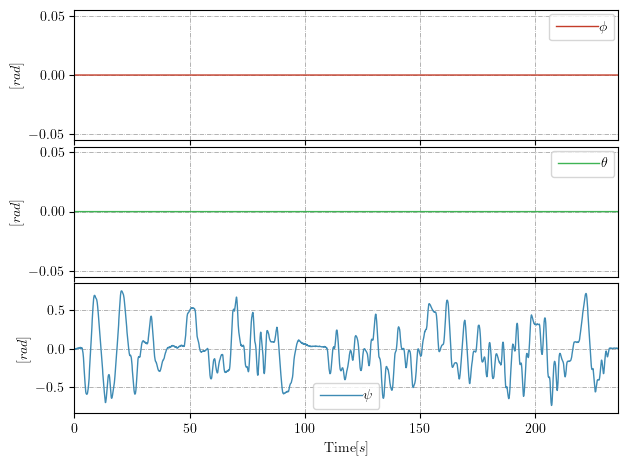

In [11]:
fig13, ax13, ax23, ax33 = fancy_plots_3()
plot_states_angles(fig13, ax13, ax23, ax33, h[7:10, :], t, "Euler Angles Of the system")
plt.show()

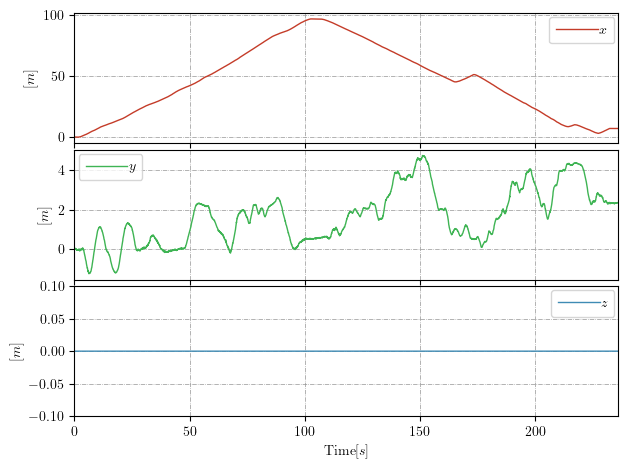

In [12]:
fig14, ax14, ax24, ax34 = fancy_plots_3()
plot_states_position(fig14, ax14, ax24, ax34, h[0:3, :], t, "Position of the system")
plt.show()

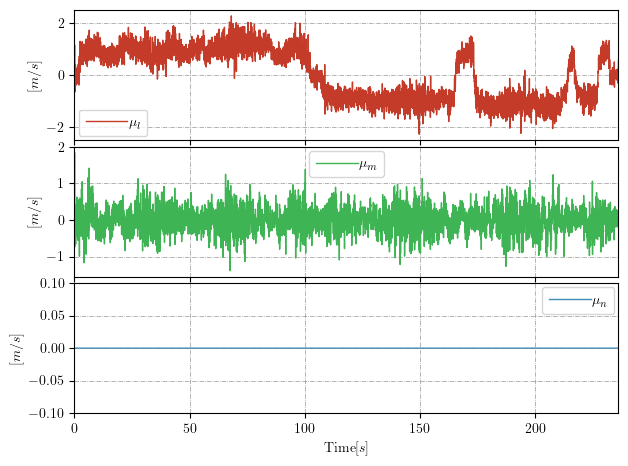

In [13]:
fig15, ax15, ax25, ax35 = fancy_plots_3()
plot_states_velocity_lineal(fig15, ax15, ax25, ax35, hp[0:3, :], t, "Lineal Velocity of the system")
plt.show()

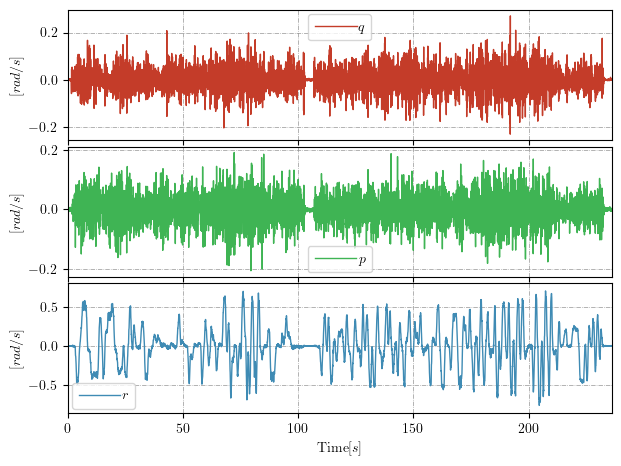

In [14]:
fig16, ax16, ax26, ax36 = fancy_plots_3()
plot_states_velocity_angular(fig16, ax16, ax26, ax36, hp[3:6, :], t, "Angular Velocity of the system")
plt.show()

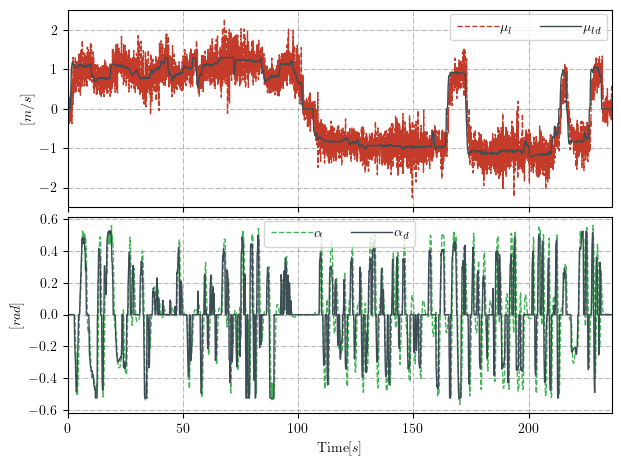

In [15]:
fig17, ax17, ax27 = fancy_plots_2()
plot_control_states(fig17, ax17, ax27, h[10:11, :], hp[0:1, :], T[:, :], t, "Control and Real Values of the system")
plt.show()

### Matrices of the System DMD Mode

In [16]:
X1, X2, U = get_simple_data(h, hp, T)
n_normal = X1.shape[0]
print(n_normal)

5


### Lift Space of the System

In [17]:
X1 = liftFun(X1)
X2 = liftFun(X2)
U = U
n = X1.shape[0]
m = U.shape[0]
print(n, m)



12 2


### Gain values training

In [18]:
alpha = 0.2
beta = 0.2

In [19]:
#cost_function_koopman(X1, X2, U, alpha, beta, n, m, n_normal)